# imports

In [1]:
import pandas as pd
import datetime as dt
import pytz
import os
import glob
import holidays
import datetime as dt
from holidays import country_holidays
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticks
import matplotlib.dates as mdates
import itertools

In [2]:
import statsmodels.tsa.api as tsa
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import pmdarima as pm
from pmdarima.arima.utils import ndiffs, nsdiffs
from pmdarima.model_selection import train_test_split

import pmdarima as pm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn import set_config

In [3]:
set_config(transform_output="pandas")
plt.rcParams['figure.figsize'] = (12,4)
plt.rcParams['figure.facecolor'] = 'white'
sns.set_context("talk", font_scale=0.9)
pd.set_option('display.max_columns',50)

# Custom functions

In [4]:
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs):
    # Save each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [5]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black', method = 'ywm'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)  
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')
    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )
    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)    
    # Annotate sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)
    # seasons
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        # Calculate number of complete seasons to annotate
        n_seasons = nlags//m 

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        # for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()
    
    return fig

In [6]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    # PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)
    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)
    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")
    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [7]:
def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [8]:
def plot_dates(ts,figsize=(12,4),xtick_fontsize='large', xtick_fontweight='bold',
               title= None):## Make the fig and axis first
    
    if title is None:
        title = ts.name
    # plot the time series with pandas
    fig, ax = plt.subplots(figsize=figsize)
    ts.plot(ax=ax,title=title);
    
    ## creating our tick locators and formatters
    ## for minor month ticks
    # create the locator to place ticks every 3 months.
    loc_3months = mdates.MonthLocator(interval=3)
    fmt_months = mdates.DateFormatter("%b")
    ## for major year ticks
    loc_year = mdates.YearLocator()
    fmt_year = mdates.DateFormatter("%Y")
    
    ## Change the font of the major ticks to stand out
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), 
                       fontsize=xtick_fontsize, 
                       fontweight=xtick_fontweight) 
    
    ## customize minor ticks
    ax.xaxis.set_minor_locator(loc_3months)
    ax.xaxis.set_minor_formatter(fmt_months)
    ## customize major ticks
    ax.xaxis.set_major_locator(loc_year)
    ax.xaxis.set_major_formatter(fmt_year)
    ## Making major/minor gridlines visually distinct
    ax.grid(which='minor',axis='x',ls=":")
    ax.grid(which='major',axis='x',color='k')
    ## rotate the dates
    fig.autofmt_xdate(which='major',rotation=90,ha='center')
    return fig,ax

In [9]:
def plot_compare_cols(state_ts,col1='cases',color1='#3b81db',
                      col2='deaths',color2='orange',
                     ylabel1="# of Total Cases", ylabel2="# of Total Deaths",
                     figsize=(12,5)):
    """#Solution for having two legends
    # Source: https://samchaaa.medium.com/how-to-plot-two-different-scales-on-one-plot-in-matplotlib-with-legend-46554ba5915a
    """
    fig, ax1 = plt.subplots(figsize=figsize)
    ax1.plot(state_ts.index, state_ts[col1] ,color=color1,label=col1.title())
    ax1.set_ylabel(ylabel1)
    # Make twin axis
    ax2 = ax1.twinx()
    ax2.plot(state_ts.index ,state_ts[col2],label=col2.title(),color=color2)
    ax2.set_ylabel(ylabel2)
    ## Removing the grids
    ax1.grid(False)
    ax2.grid(False)
    ## Making joined legend
    lines = ax1.get_lines() + ax2.get_lines()
    labels = [l.get_label() for l in lines]
    ax2.legend(lines, labels, loc=0);
    fig.autofmt_xdate()
    return fig, (ax1,ax2)

# load data

In [10]:
zillow_df = pd.read_csv('/Users/marcolaureano2/Documents/GitHub/Marco-Laureano_DV_exam_c/data/zillow_home_values-zipcode.csv')
zillow_df

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,31012000,29022000,31032000,30042000,31052000,30062000,31072000,31082000,30092000,31102000,30112000,31122000,31012001,28022001,31032001,30042001,...,30112020,31122020,31012021,28022021,31032021,30042021,31052021,30062021,31072021,31082021,30092021,31102021,30112021,31122021,31012022,28022022,31032022,30042022,31052022,30062022,31072022,31082022,30092022,31102022,30112022
0,91940,0,77449,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,107261.0,107274.0,107076.0,107081.0,107112.0,107325.0,107480.0,107709.0,108092.0,108328.0,108782.0,109187.0,109242.0,109045.0,108514.0,108330.0,...,204564.0,206902.0,209154.0,212069.0,213553.0,215782.0,218494.0,223994.0,229959.0,236318.0,241418.0,246015.0,249379.0,253321.0,257274.0,261945.0,267644.0,273946.0,280066.0,285121.0,288532.0,290458.0,291103.0,292081.0,292948.0
1,91982,1,77494,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,222569.0,222885.0,223602.0,224818.0,224384.0,224051.0,222942.0,223281.0,222886.0,223553.0,224715.0,226127.0,226742.0,226052.0,225191.0,224344.0,...,346146.0,350598.0,354599.0,359133.0,364502.0,370992.0,377896.0,386576.0,397227.0,408018.0,417061.0,424951.0,431973.0,437659.0,443701.0,453150.0,464727.0,478369.0,489712.0,497173.0,499429.0,497572.0,498113.0,500187.0,503109.0
2,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,90009.0,90009.0,90042.0,90007.0,90027.0,89987.0,89972.0,89926.0,89397.0,88767.0,87904.0,87765.0,87719.0,87845.0,87409.0,87119.0,...,144471.0,146280.0,147989.0,149669.0,151475.0,153251.0,155948.0,158804.0,161832.0,164617.0,167493.0,169790.0,171741.0,173354.0,175355.0,177319.0,179463.0,182812.0,186403.0,189836.0,192064.0,193760.0,195140.0,196787.0,198137.0
3,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,188096.0,190588.0,192155.0,194686.0,196246.0,198131.0,200596.0,202906.0,205407.0,208731.0,212367.0,215368.0,217915.0,220488.0,223666.0,226950.0,...,583072.0,582981.0,580157.0,578240.0,577104.0,577493.0,579678.0,579581.0,579996.0,579154.0,580023.0,578203.0,576272.0,572245.0,570414.0,570211.0,572145.0,573662.0,576469.0,578706.0,580834.0,581779.0,584566.0,588188.0,590722.0
4,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,275983.0,277855.0,279802.0,282271.0,283679.0,284880.0,285975.0,288330.0,290339.0,293681.0,296592.0,299017.0,300344.0,302885.0,307212.0,311950.0,...,712619.0,716779.0,721142.0,722880.0,723884.0,724676.0,730056.0,733300.0,735223.0,734912.0,738325.0,741995.0,745001.0,745550.0,748738.0,752025.0,757734.0,760336.0,766163.0,771443.0,776607.0,779281.0,782367.0,788211.0,793924.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27437,80190,30657,50160,zip,IA,IA,Martensdale,"Des Moines-West Des Moines, IA",Warren County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,143780.0,144308.0,145210.0,146499.0,148291.0,150535.0,152595.0,154855.0,157873.0,160066.0,163636.0,165020.0,168403.0,171162.0,175711.0,179118.0,180140.0,181125.0,182326.0,184931.0,186807.0,188354.0,190188.0,191768.0,193591.0
27438,65355,30657,18081,zip,PA,PA,Hellertown,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",Bucks County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,324834.0,333472.0,340349.0,341377.0,341492.0,342488.0,347636.0,352781.0,355540.0,356345.0,358872.0,364462.0,370884.0,374839.0,375156.0,374141.0,372143.0,371578.0,372879.0,376523.0
27439,82217,30657,55366,zip,MN,MN,NaN,NaN,Sibley County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110082.0
27440,80581,30657,51009,zip,IA,IA,Calumet,NaN,O Brien County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

# part 1

In [11]:
zillow_df.columns

Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'City', 'Metro', 'CountyName', '31012000',
       ...
       '28022022', '31032022', '30042022', '31052022', '30062022', '31072022',
       '31082022', '30092022', '31102022', '30112022'],
      dtype='object', length=284)

In [12]:
zillow_melt = pd.melt(zillow_df, id_vars=['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName'])
zillow_melt

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,variable,value
0,91940,0,77449,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,31012000,107261.0
1,91982,1,77494,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,31012000,222569.0
2,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,31012000,90009.0
3,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,31012000,188096.0
4,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,31012000,275983.0
...,...,...,...,...,...,...,...,...,...,...,...
7546545,80190,30657,50160,zip,IA,IA,Martensdale,"Des Moines-West Des Moines, IA",Warren County,30112022,193591.0
7546546,65355,30657,18081,zip,PA,PA,Hellertown,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",Bucks County,30112022,376523.0
7546547,82217,30657,55366,zip,MN,MN,NaN,NaN,Sibley County,30112022,110082.0
7546548,80581,30657,51009,zip,IA,IA,Calumet,NaN,O Brien County,30112022,75810.0


In [13]:
zillow_melt = zillow_melt.rename(columns = {'variable': 'date', 'value': 'HomeValue'})
zillow_melt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7546550 entries, 0 to 7546549
Data columns (total 11 columns):
 #   Column      Dtype  
---  ------      -----  
 0   RegionID    int64  
 1   SizeRank    int64  
 2   RegionName  int64  
 3   RegionType  object 
 4   StateName   object 
 5   State       object 
 6   City        object 
 7   Metro       object 
 8   CountyName  object 
 9   date        object 
 10  HomeValue   float64
dtypes: float64(1), int64(3), object(7)
memory usage: 633.3+ MB


In [14]:
zillow_melt['date'] = pd.to_datetime(zillow_melt['date'], format = '%d%m%Y')
zillow_melt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7546550 entries, 0 to 7546549
Data columns (total 11 columns):
 #   Column      Dtype         
---  ------      -----         
 0   RegionID    int64         
 1   SizeRank    int64         
 2   RegionName  int64         
 3   RegionType  object        
 4   StateName   object        
 5   State       object        
 6   City        object        
 7   Metro       object        
 8   CountyName  object        
 9   date        datetime64[ns]
 10  HomeValue   float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(6)
memory usage: 633.3+ MB


In [15]:
zillow_melt = zillow_melt.set_index('date')
zillow_melt

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,HomeValue
date,,,,,,,,,,
2000-01-31,91940,0,77449,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,107261.0
2000-01-31,91982,1,77494,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,222569.0
2000-01-31,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,90009.0
2000-01-31,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,188096.0
2000-01-31,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,275983.0
...,...,...,...,...,...,...,...,...,...,...
2022-11-30,80190,30657,50160,zip,IA,IA,Martensdale,"Des Moines-West Des Moines, IA",Warren County,193591.0
2022-11-30,65355,30657,18081,zip,PA,PA,Hellertown,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",Bucks County,376523.0
2022-11-30,82217,30657,55366,zip,MN,MN,NaN,NaN,Sibley County,110082.0


In [16]:
states_list = ['CO', 'UT', 'WY', 'KS', 'NE']

In [17]:
zillow_range = zillow_melt.loc['2006': '2016'].copy()

In [18]:
zillow_range = zillow_range[zillow_range.StateName.isin(states_list)]
zillow_range

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,HomeValue
date,,,,,,,,,,
2006-01-31,87074,120,66062,zip,KS,KS,Olathe,"Kansas City, MO-KS",Johnson County,199045.0
2006-01-31,93203,178,80013,zip,CO,CO,Aurora,"Denver-Aurora-Lakewood, CO",Arapahoe County,224280.0
2006-01-31,93205,208,80015,zip,CO,CO,Centennial,"Denver-Aurora-Lakewood, CO",Arapahoe County,269218.0
2006-01-31,93295,228,80219,zip,CO,CO,Denver,"Denver-Aurora-Lakewood, CO",Denver County,195351.0
2006-01-31,87073,286,66061,zip,KS,KS,Olathe,"Kansas City, MO-KS",Johnson County,199538.0
...,...,...,...,...,...,...,...,...,...,...
2016-12-31,94400,30657,84033,zip,UT,UT,Echo,"Heber, UT",Summit County,286994.0
2016-12-31,87406,30657,67016,zip,KS,KS,Sedgwick,"Wichita, KS",Sedgwick County,107731.0
2016-12-31,93650,30657,81030,zip,CO,CO,La Junta,NaN,Otero County,99129.0


In [19]:
zillow_range.to_csv('/Users/marcolaureano2/Documents/GitHub/Marco-Laureano_DV_exam_c/data/data-fo-tableau.csv')

In [20]:
zillow_range.index

DatetimeIndex(['2006-01-31', '2006-01-31', '2006-01-31', '2006-01-31',
               '2006-01-31', '2006-01-31', '2006-01-31', '2006-01-31',
               '2006-01-31', '2006-01-31',
               ...
               '2016-12-31', '2016-12-31', '2016-12-31', '2016-12-31',
               '2016-12-31', '2016-12-31', '2016-12-31', '2016-12-31',
               '2016-12-31', '2016-12-31'],
              dtype='datetime64[ns]', name='date', length=223080, freq=None)

In [21]:
zillow_range_plot = zillow_range.groupby('State').resample('AS').mean().copy()
zillow_range_plot

/var/folders/jx/cpydz30j3y523cvb2w4sjv7h0000gn/T/ipykernel_3759/3474018934.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  zillow_range_plot = zillow_range.groupby('State').resample('AS').mean().copy()


RegionID      SizeRank    RegionName      HomeValue
State date                                                                
CO    2006-01-01   98931.609272  14775.653422  80761.041943  270736.718310
      2007-01-01   98931.609272  14775.653422  80761.041943  276757.021389
      2008-01-01   98931.609272  14775.653422  80761.041943  268344.378318
      2009-01-01   98931.609272  14775.653422  80761.041943  254229.031910
      2010-01-01   98931.609272  14775.653422  80761.041943  244582.998657
      2011-01-01   98931.609272  14775.653422  80761.041943  234979.265473
      2012-01-01   98931.609272  14775.653422  80761.041943  235184.418919
      2013-01-01   98931.609272  14775.653422  80761.041943  248286.167978
      2014-01-01   98931.609272  14775.653422  80761.041943  268037.539201
      2015-01-01   98931.609272  14775.653422  80761.041943  290111.457283
      2016-01-01   98931.609272  14775.653422  80761.041943  311843.357756
KS    2006-01-01   87370.020367  18869.668024  66879.594705  164954.185847
      2007-01-01   87370.020367  18869.668024  66879.594705  169191.760748
      2008-01-01   87370.020367  18869.668024  66879.594705  168116.583473
      2009-01-01   87370.020367  18869.668024  66879.594705  155173.475203
      2010-01-01   87370.020367  18869.668024  66879.594705  145031.657811
      2011-01-01   87370.020367  18869.668024  66879.594705  133622.077809
      2012-01-01   87370.020367  18869.668024  66879.594705  122588.916877
      2013-01-01   87370.020367  18869.668024  66879.594705  123422.271958
      2014-01-01   87370.020367  18869.668024  66879.594705  125734.163164
      2015-01-01   87370.020367  18869.668024  66879.594705  129807.303676
      2016-01-01   87370.020367  18869.668024  66879.594705  134432.830442
NE    2006-01-01   88070.313817  20381.037471  68578.203747  153086.089708
      2007-01-01   88070.313817  20381.037471  68578.203747  150311.184698
      2008-01-01   88070.313817  20381.037471  68578.203747  143997.143049
      2009-01-01   88070.313817  20381.037471  68578.203747  136947.384036
      2010-01-01   88070.313817  20381.037471  68578.203747  134606.662684
      2011-01-01   88070.313817  20381.037471  68578.203747  131055.288903
      2012-01-01   88070.313817  20381.037471  68578.203747  131621.769462
      2013-01-01   88070.313817  20381.037471  68578.203747  136087.065108
      2014-01-01   88070.313817  20381.037471  68578.203747  139361.876963
      2015-01-01   88070.313817  20381.037471  68578.203747  144859.287634
      2016-01-01   88070.313817  20381.037471  68578.203747  151648.716081
UT    2006-01-01  104728.282297  14112.961722  84333.244019  238977.770771
      2007-01-01  104728.282297  14112.961722  84333.244019  288692.662791
      2008-01-01  104728.282297  14112.961722  84333.244019  291327.124081
      2009-01-01  104728.282297  14112.961722  84333.244019  255891.993084
      2010-01-01  104728.282297  14112.961722  84333.244019  236743.512821
      2011-01-01  104728.282297  14112.961722  84333.244019  217856.020531
      2012-01-01  104728.282297  14112.961722  84333.244019  211016.845876
      2013-01-01  104728.282297  14112.961722  84333.244019  230911.653292
      2014-01-01  104728.282297  14112.961722  84333.244019  244047.397051
      2015-01-01  104728.282297  14112.961722  84333.244019  254618.686970
      2016-01-01  104728.282297  14112.961722  84333.244019  271108.532593
WY    2006-01-01   93946.763636  20476.618182  82554.990909  178721.000000
      2007-01-01   93946.763636  20476.618182  82554.990909  190985.816667
      2008-01-01   93946.763636  20476.618182  82554.990909  186665.666667
      2009-01-01   93946.763636  20476.618182  82554.990909  230157.611399
      2010-01-01   93946.763636  20476.618182  82554.990909  239044.332770
      2011-01-01   93946.763636  20476.618182  82554.990909  235275.488959
      2012-01-01   93946.763636  20476.618182  82554.990909  235165.835870
      2013-01-01   93946.763636  20476.618182  8

In [22]:
zillow_range_plot.index.get_level_values(1)

DatetimeIndex(['2006-01-01', '2007-01-01', '2008-01-01', '2009-01-01',
               '2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01',
               '2014-01-01', '2015-01-01', '2016-01-01', '2006-01-01',
               '2007-01-01', '2008-01-01', '2009-01-01', '2010-01-01',
               '2011-01-01', '2012-01-01', '2013-01-01', '2014-01-01',
               '2015-01-01', '2016-01-01', '2006-01-01', '2007-01-01',
               '2008-01-01', '2009-01-01', '2010-01-01', '2011-01-01',
               '2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01',
               '2016-01-01', '2006-01-01', '2007-01-01', '2008-01-01',
               '2009-01-01', '2010-01-01', '2011-01-01', '2012-01-01',
               '2013-01-01', '2014-01-01', '2015-01-01', '2016-01-01',
               '2006-01-01', '2007-01-01', '2008-01-01', '2009-01-01',
               '2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01',
               '2014-01-01', '2015-01-01', '2016-01-01'],
              dtype

In [23]:
unstacked = zillow_range_plot.unstack(level=1)
unstacked

RegionID                                               \
date      2006-01-01     2007-01-01     2008-01-01     2009-01-01   
State                                                               
CO      98931.609272   98931.609272   98931.609272   98931.609272   
KS      87370.020367   87370.020367   87370.020367   87370.020367   
NE      88070.313817   88070.313817   88070.313817   88070.313817   
UT     104728.282297  104728.282297  104728.282297  104728.282297   
WY      93946.763636   93946.763636   93946.763636   93946.763636   

                                                                   \
date      2010-01-01     2011-01-01     2012-01-01     2013-01-01   
State                                                               
CO      98931.609272   98931.609272   98931.609272   98931.609272   
KS      87370.020367   87370.020367   87370.020367   87370.020367   
NE      88070.313817   88070.313817   88070.313817   88070.313817   
UT     104728.282297  104728.282297  104728.282297  104728.282297   
WY      93946.763636   93946.763636   93946.763636   93946.763636   

                                                        SizeRank  \
date      2014-01-01     2015-01-01     2016-01-01    2006-01-01   
State                                                              
CO      98931.609272   98931.609272   98931.609272  14775.653422   
KS      87370.020367   87370.020367   87370.020367  18869.668024   
NE      88070.313817   88070.313817   88070.313817  20381.037471   
UT     104728.282297  104728.282297  104728.282297  14112.961722   
WY      93946.763636   93946.763636   93946.763636  20476.618182   

                                                                             \
date     2007-01-01    2008-01-01    2009-01-01    2010-01-01    2011-01-01   
State                                                                         
CO     14775.653422  14775.653422  14775.653422  14775.653422  14775.653422   
KS     18869.668024  18869.668024  18869.668024  18869.668024  18869.668024   
NE     20381.037471  20381.037471  20381.037471  20381.037471  20381.037471   
UT     14112.961722  14112.961722  14112.961722  14112.961722  14112.961722   
WY     20476.618182  20476.618182  20476.618182  20476.618182  20476.618182   

                                                                             \
date     2012-01-01    2013-01-01    2014-01-01    2015-01-01    2016-01-01   
State                                                                         
CO     14775.653422  14775.653422  14775.653422  14775.653422  14775.653422   
KS     18869.668024  18869.668024  18869.668024  18869.668024  18869.668024   
NE     20381.037471  20381.037471  20381.037471  20381.037471  20381.037471   
UT     14112.961722  14112.961722  14112.961722  14112.961722  14112.961722   
WY     20476.618182  20476.618182  20476.618182  20476.618182  20476.618182   

         RegionName                                                          \
date     2006-01-01    2007-01-01    2008-01-01    2009-01-01    2010-01-01   
State                                                                         
CO     80761.041943  80761.041943  80761.041943  80761.041943  80761.041943   
KS     66879.594705  66879.594705  66879.594705  66879.594705  66879.594705   
NE     68578.203747  68578.203747  68578.203747  68578.203747  68578.203747   
UT     84333.244019  84333.244019  84333.244019  84333.244019  84333.244019   
WY     82554.990909  82554.990909  82554.990909  82554.990909  82554.990909   

                                                                             \
date     2011-01-01    2012-01-01    2013-01-01    2014-01-01    2015-01-01   
State                                                                         
CO     80761.041943  80761.041943  80761.041943  80761.041943  80761.041943   
KS     66879.594705  66879.594705  66879.594705  66879.594705  66879.594705   
NE     68578.203747  68578.203747  68578.203747  68578.203747  6857

In [24]:
ts_co = zillow_range_plot.loc['CO', 'HomeValue']
ts_co.index

DatetimeIndex(['2006-01-01', '2007-01-01', '2008-01-01', '2009-01-01',
               '2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01',
               '2014-01-01', '2015-01-01', '2016-01-01'],
              dtype='datetime64[ns]', name='date', freq='AS-JAN')

In [25]:
ts_ks = zillow_range_plot.loc['KS', 'HomeValue']
ts_ks.index

DatetimeIndex(['2006-01-01', '2007-01-01', '2008-01-01', '2009-01-01',
               '2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01',
               '2014-01-01', '2015-01-01', '2016-01-01'],
              dtype='datetime64[ns]', name='date', freq='AS-JAN')

In [26]:
ts_ne = zillow_range_plot.loc['NE', 'HomeValue']
ts_ne.index

DatetimeIndex(['2006-01-01', '2007-01-01', '2008-01-01', '2009-01-01',
               '2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01',
               '2014-01-01', '2015-01-01', '2016-01-01'],
              dtype='datetime64[ns]', name='date', freq='AS-JAN')

In [27]:
ts_ut = zillow_range_plot.loc['UT', 'HomeValue']
ts_ut.index

DatetimeIndex(['2006-01-01', '2007-01-01', '2008-01-01', '2009-01-01',
               '2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01',
               '2014-01-01', '2015-01-01', '2016-01-01'],
              dtype='datetime64[ns]', name='date', freq='AS-JAN')

In [28]:
ts_wy = zillow_range_plot.loc['WY', 'HomeValue']
ts_wy.index

DatetimeIndex(['2006-01-01', '2007-01-01', '2008-01-01', '2009-01-01',
               '2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01',
               '2014-01-01', '2015-01-01', '2016-01-01'],
              dtype='datetime64[ns]', name='date', freq='AS-JAN')

In [29]:
compare_ts = pd.DataFrame({'CO': ts_co, 'KS': ts_ks, 'NE': ts_ne, 'UT': ts_ut, 'WY': ts_wy})
compare_ts

,CO,KS,NE,UT,WY
date,,,,,
2006-01-01,270736.718310,164954.185847,153086.089708,238977.770771,178721.000000
2007-01-01,276757.021389,169191.760748,150311.184698,288692.662791,190985.816667
2008-01-01,268344.378318,168116.583473,143997.143049,291327.124081,186665.666667
2009-01-01,254229.031910,155173.475203,136947.384036,255891.993084,230157.611399
2010-01-01,244582.998657,145031.657811,134606.662684,236743.512821,239044.332770
2011-01-01,234979.265473,133622.077809,131055.288903,217856.020531,235275.488959
2012-01-01,235184.418919,122588.916877,131621.769462,211016.845876,235165.835870
2013-01-01,248286.167978,123422.271958,136087.065108,230911.653292,243776.909610
2014-01-01,268037.539201,125734.163164,139361.876963,244047.397051,253225.814847


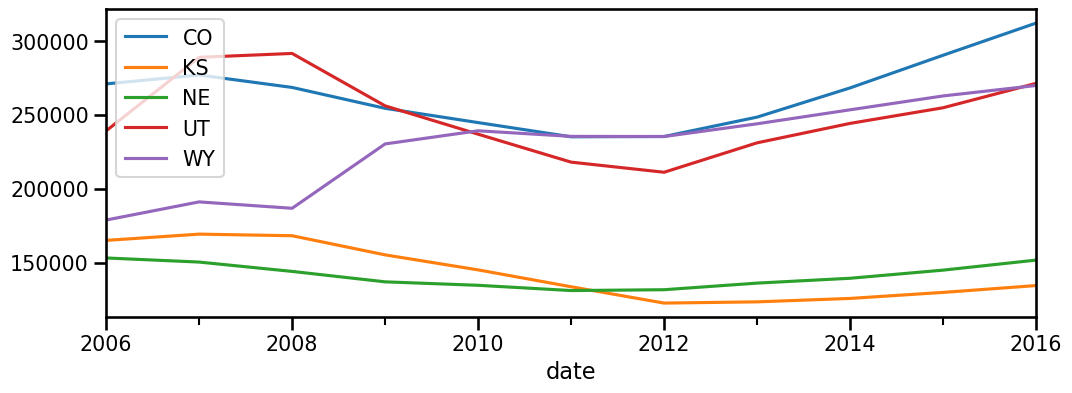

In [30]:
compare_ts.plot();

# Part 2

In [31]:
compare_ts.isna().sum()

CO    0
KS    0
NE    0
UT    0
WY    0
dtype: int64

In [32]:
z_range = zillow_melt.loc['2008': '2018'].copy()

In [33]:
z_range

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,HomeValue
date,,,,,,,,,,
2008-01-31,91940,0,77449,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,132717.0
2008-01-31,91982,1,77494,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,262822.0
2008-01-31,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,133650.0
2008-01-31,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,447718.0
2008-01-31,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,538860.0
...,...,...,...,...,...,...,...,...,...,...
2018-12-31,80190,30657,50160,zip,IA,IA,Martensdale,"Des Moines-West Des Moines, IA",Warren County,131357.0
2018-12-31,65355,30657,18081,zip,PA,PA,Hellertown,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",Bucks County,NaN
2018-12-31,82217,30657,55366,zip,MN,MN,NaN,NaN,Sibley County,NaN


In [34]:
co_filter = ['CO']

In [35]:
z_range = z_range[z_range.StateName.isin(co_filter)]
z_range

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,HomeValue
date,,,,,,,,,,
2008-01-31,93203,178,80013,zip,CO,CO,Aurora,"Denver-Aurora-Lakewood, CO",Arapahoe County,209431.0
2008-01-31,93205,208,80015,zip,CO,CO,Centennial,"Denver-Aurora-Lakewood, CO",Arapahoe County,255727.0
2008-01-31,93295,228,80219,zip,CO,CO,Denver,"Denver-Aurora-Lakewood, CO",Denver County,172213.0
2008-01-31,93263,288,80134,zip,CO,CO,Parker,"Denver-Aurora-Lakewood, CO",Douglas County,336323.0
2008-01-31,93487,458,80631,zip,CO,CO,Greeley,"Greeley, CO",Weld County,154417.0
...,...,...,...,...,...,...,...,...,...,...
2018-12-31,93260,30657,80131,zip,CO,CO,Louviers,"Denver-Aurora-Lakewood, CO",Douglas County,424117.0
2018-12-31,93484,30657,80622,zip,CO,CO,Galeton,"Greeley, CO",Weld County,NaN
2018-12-31,93402,30657,80453,zip,CO,CO,Idledale,"Denver-Aurora-Lakewood, CO",Jefferson County,395951.0


In [36]:
z_range.isna().sum()

RegionID          0
SizeRank          0
RegionName        0
RegionType        0
StateName         0
State             0
City           2376
Metro         16368
CountyName        0
HomeValue      8236
dtype: int64

In [37]:
z_range.isna().sum()

RegionID          0
SizeRank          0
RegionName        0
RegionType        0
StateName         0
State             0
City           2376
Metro         16368
CountyName        0
HomeValue      8236
dtype: int64

In [38]:
z_range = z_range.dropna()

In [39]:
z_range.isna().sum()

RegionID      0
SizeRank      0
RegionName    0
RegionType    0
StateName     0
State         0
City          0
Metro         0
CountyName    0
HomeValue     0
dtype: int64

In [40]:
z_range = z_range.drop(columns = ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', 'State', 'Metro']).copy()

In [41]:
z_range = z_range.drop(columns = ['City', 'CountyName'])

In [43]:
z_range.index

DatetimeIndex(['2008-01-31', '2008-01-31', '2008-01-31', '2008-01-31',
               '2008-01-31', '2008-01-31', '2008-01-31', '2008-01-31',
               '2008-01-31', '2008-01-31',
               ...
               '2018-12-31', '2018-12-31', '2018-12-31', '2018-12-31',
               '2018-12-31', '2018-12-31', '2018-12-31', '2018-12-31',
               '2018-12-31', '2018-12-31'],
              dtype='datetime64[ns]', name='date', length=38565, freq=None)

In [46]:
z_range

,HomeValue
date,
2008-01-31,209431.0
2008-01-31,255727.0
2008-01-31,172213.0
2008-01-31,336323.0
2008-01-31,154417.0
...,...
2018-12-31,351270.0
2018-12-31,258008.0
2018-12-31,424117.0


In [78]:
z_resample = z_range.resample('M').mean()

In [79]:
z_resample.index

DatetimeIndex(['2008-01-31', '2008-02-29', '2008-03-31', '2008-04-30',
               '2008-05-31', '2008-06-30', '2008-07-31', '2008-08-31',
               '2008-09-30', '2008-10-31',
               ...
               '2018-03-31', '2018-04-30', '2018-05-31', '2018-06-30',
               '2018-07-31', '2018-08-31', '2018-09-30', '2018-10-31',
               '2018-11-30', '2018-12-31'],
              dtype='datetime64[ns]', name='date', length=132, freq='M')

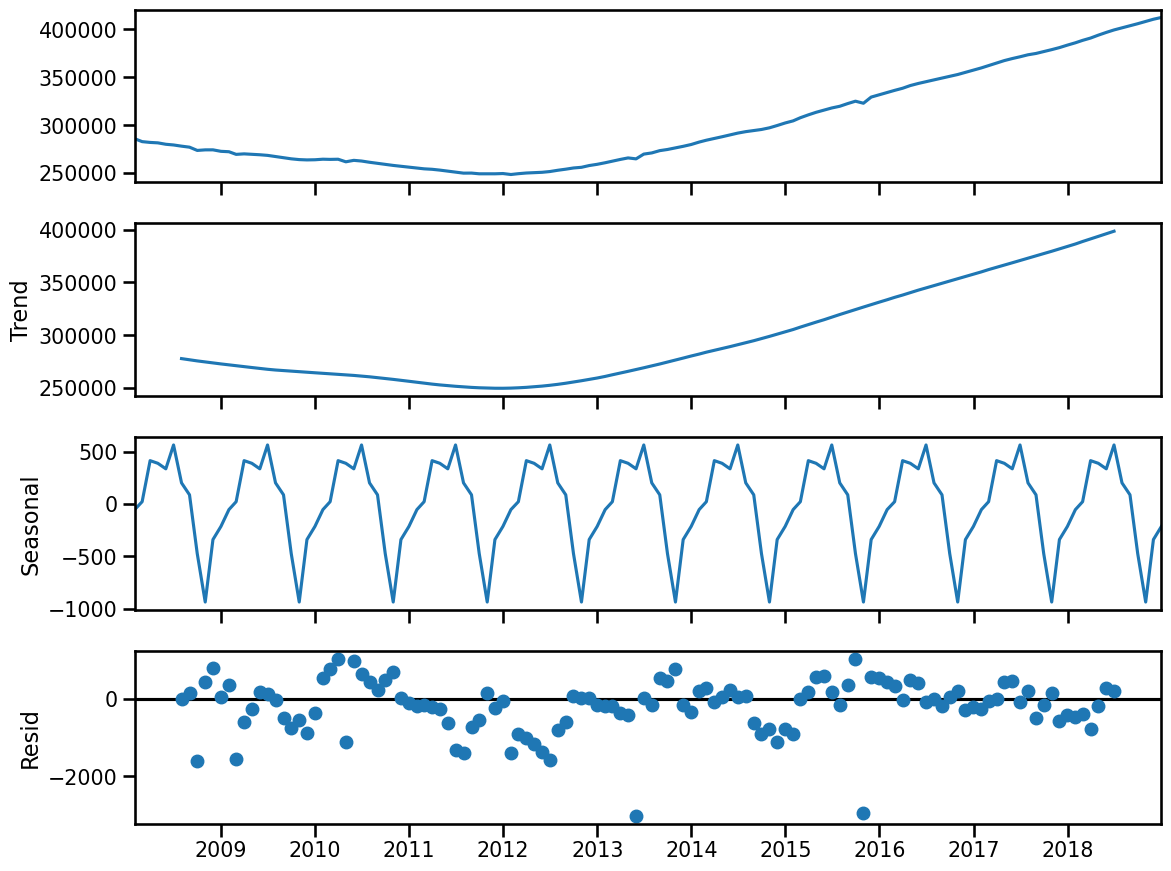

In [80]:
z_decomp = tsa.seasonal_decompose(z_resample)
fig = z_decomp.plot()
fig.set_size_inches(12, 9)
fig.tight_layout()

In [88]:
get_adfuller_results(z_resample)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-0.156322,5,126,0.943532,0.05,False


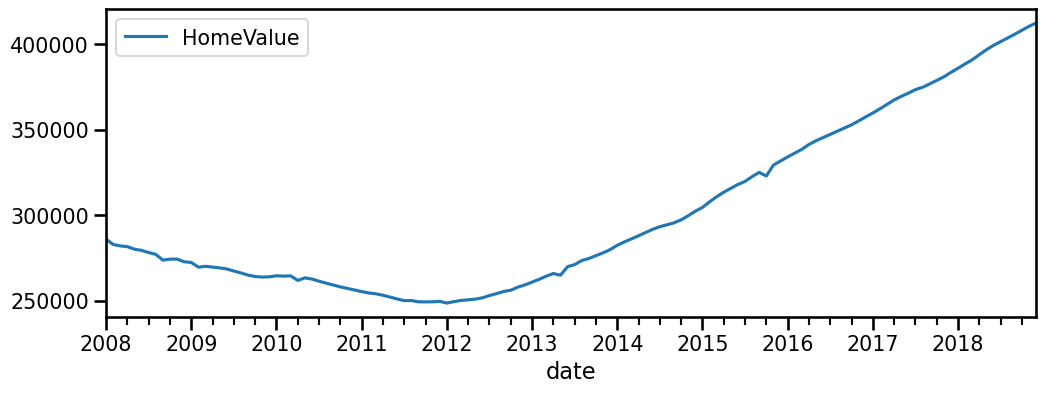

In [89]:
z_resample.plot();

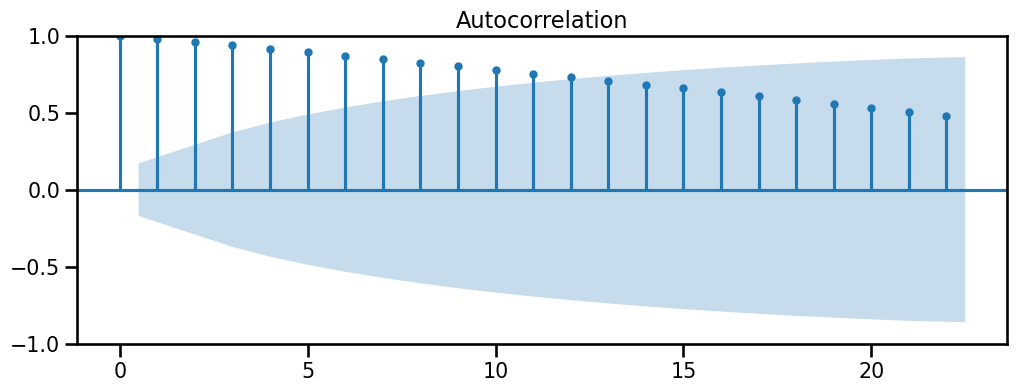

In [93]:
tsa.graphics.plot_acf(z_resample);

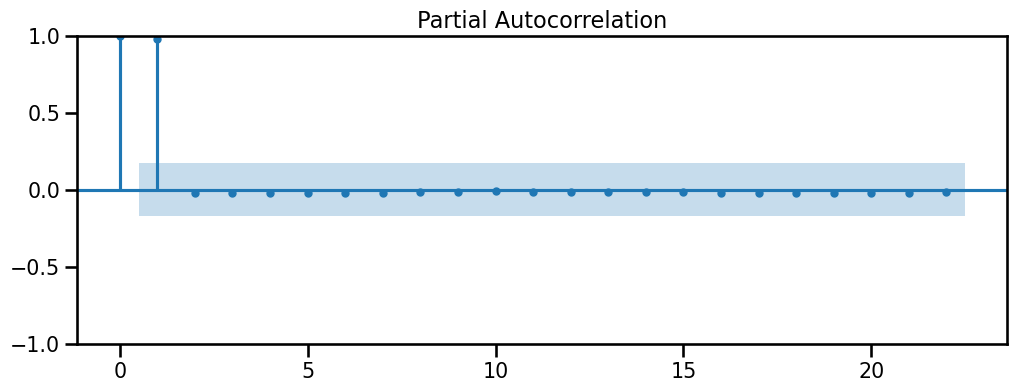

In [91]:
tsa.graphics.plot_pacf(z_resample);

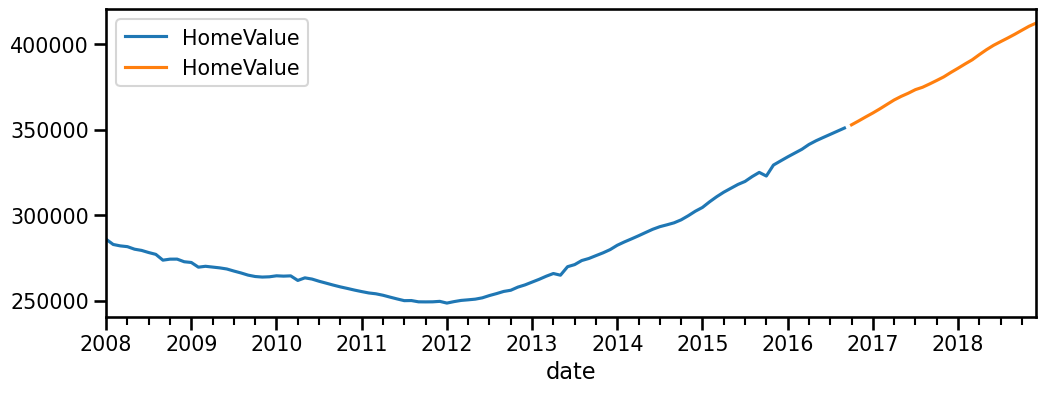

In [94]:
train, test = train_test_split(z_resample, test_size = .20)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

In [96]:
p = 1
d = 1
q = 0

ar_model = tsa.ARIMA(train, order = (p,d,q)).fit()
ar_model

In [97]:
ar_model.params

ar.L1    -9.961740e-03
sigma2    3.159050e+06
dtype: float64

In [98]:
forecast_df = ar_model.get_forecast(steps=len(test)).summary_frame()
forecast_df.head()

HomeValue,mean,mean_se,mean_ci_lower,mean_ci_upper
2016-10-31,350873.532264,1777.371599,347389.947943,354357.116585
2016-11-30,350873.715535,2501.094525,345971.660343,355775.770727
2016-12-31,350873.713709,3058.188781,344879.773841,356867.653578
2017-01-31,350873.713728,3528.393010,343958.190505,357789.236950
2017-02-28,350873.713727,3942.917182,343145.738057,358601.689398


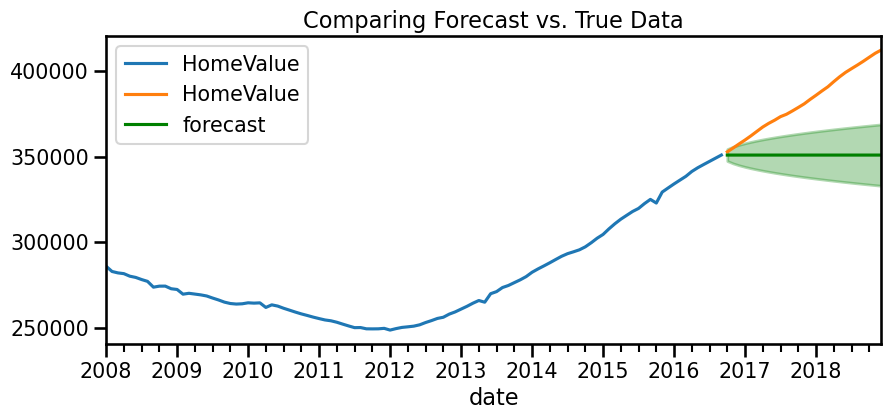

In [99]:
plot_forecast(train, test, forecast_df);

In [100]:
regression_metrics_ts(test, forecast_df['mean'])

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 31,488.998
- MSE = 1,311,061,408.356
- RMSE = 36,208.582
- R^2 = -3.103
- MAPE = 8.03%


In [101]:
# sarima
d = ndiffs(z_resample)
d

2

In [102]:
D = nsdiffs(z_resample, m=12)
D

0

In [103]:
z_diffs = z_resample.diff().dropna()

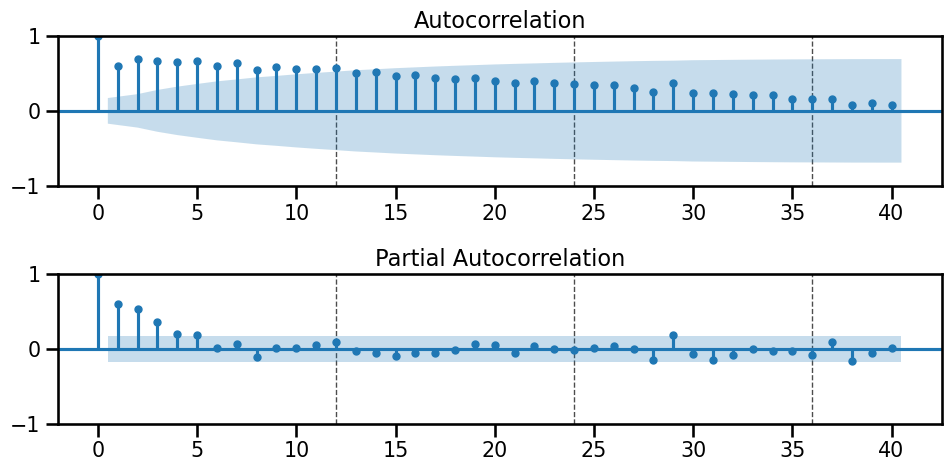

In [105]:
plot_acf_pacf(z_diffs, annotate_seas=True, m = 12, method = 'ywm');

In [107]:
# non seasonal components
p = 2
d = 0
q = 1

# seasonal components
P = 1
D = 0
Q = 0 
m = 12

sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order = (P, D, Q, m)).fit()

/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 31,488.998
- MSE = 1,311,061,408.356
- RMSE = 36,208.582
- R^2 = -3.103
- MAPE = 8.03%


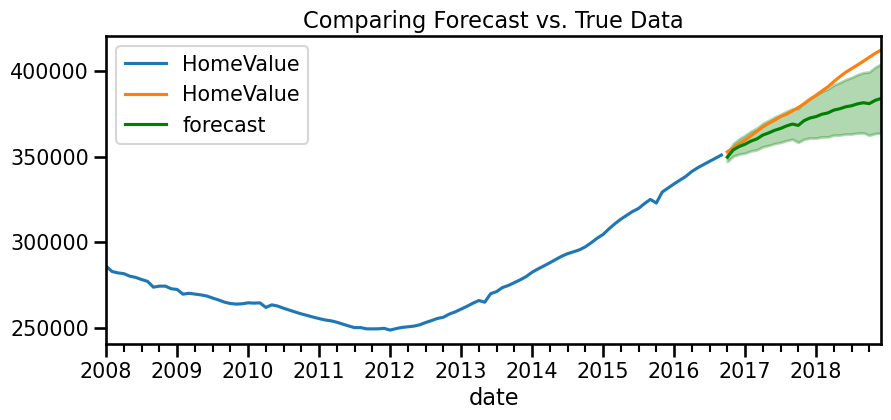

In [108]:
forecast_2 = sarima.get_forecast(len(test)).summary_frame()
plot_forecast(train, test, forecast_2)
regression_metrics_ts(test, forecast_df['mean'])

In [109]:
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                         HomeValue   No. Observations:                  105
Model:             ARIMA(2, 0, 1)x(1, 0, [], 12)   Log Likelihood                -909.435
Date:                           Wed, 08 Nov 2023   AIC                           1830.871
Time:                                   19:13:54   BIC                           1846.794
Sample:                               01-31-2008   HQIC                          1837.323
                                    - 09-30-2016                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.799e+05    9.3e-09   3.01e+13      0.000     2.8e+05     2.8e+05
ar.L1          0.0546      0.053      1.026      0.305      -0.050       0.159
ar.L2          0.9431      0.054     17.521      0.000       0.838       1.049
ma.L1          1.0000      0.109      9.180      0.000       0.786       1.214
ar.S.L12       0.7167      0.097      7.383      0.000       0.526       0.907
sigma2      1.656e+06   6.58e-08   2.52e+13      0.000    1.66e+06    1.66e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                15.37
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               2.03   Skew:                             0.22
Prob(H) (two-sided):                  0.04   Kurtosis:                         4.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.02e+29. Standard errors may be unstable.
"""

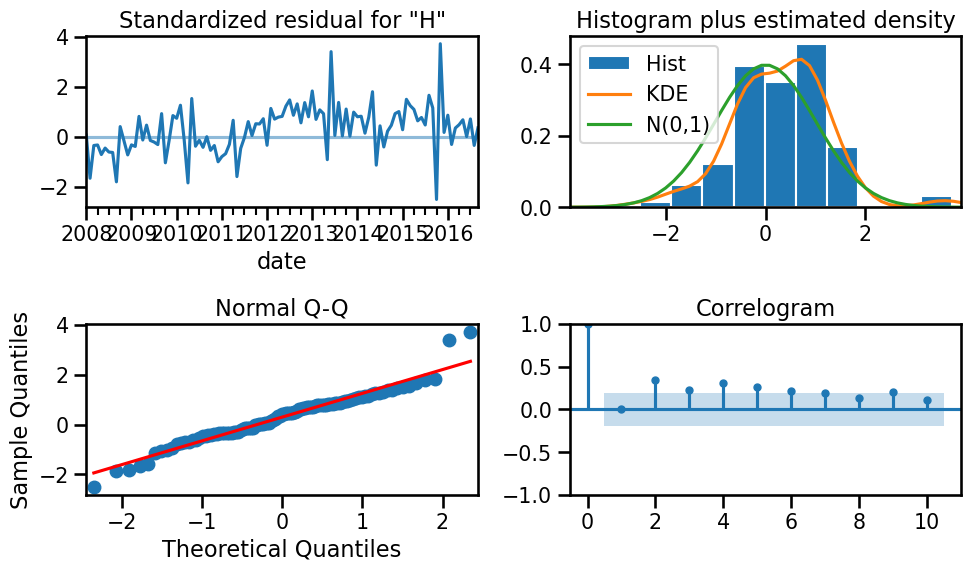

In [110]:
fig = sarima.plot_diagnostics()
fig.set_size_inches(10, 6)
fig.tight_layout()

In [111]:
# Define the value or range of values for p, d, q
p_values = range(0, 3)  
d_values = [0]          
q_values = range(0, 3)  
P_values = range (0, 3)
D_values = [0]
Q_values = range (0,3)
m = [12]

# Create combinations of pdq to test
pdqPDQm_to_try = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, m))

# Display first 10 combinations
pdqPDQm_to_try[:10]

[(0, 0, 0, 0, 0, 0, 12),
 (0, 0, 0, 0, 0, 1, 12),
 (0, 0, 0, 0, 0, 2, 12),
 (0, 0, 0, 1, 0, 0, 12),
 (0, 0, 0, 1, 0, 1, 12),
 (0, 0, 0, 1, 0, 2, 12),
 (0, 0, 0, 2, 0, 0, 12),
 (0, 0, 0, 2, 0, 1, 12),
 (0, 0, 0, 2, 0, 2, 12),
 (0, 0, 1, 0, 0, 0, 12)]

In [ ]:
# define starting aic as infinity
best_aic = float("inf")  

# define baseline for pdq
best_pdqPDQm = (0,0,0,0,0,0,0)

# Loop through each combination
for pdqPDQm in pdqPDQm_to_try:
    order = pdqPDQm[:3] # first three values are non seasonal (p,d,q)
    seasonal_order = pdqPDQm[3:] # Remaining values for seasonal (P,D,Q,m)
    
    model = tsa.ARIMA(train, order=order, seasonal_order = seasonal_order)
    try:                         
        result = model.fit()
        print(pdqPDQm, result.aic)      
   
    except:
        print(f'{pdqPDQm}: caused an error')
    
    # If lower, replace best AIC with new value
    if result.aic < best_aic:
        
        best_aic = result.aic
        best_pdqPDQm = pdqPDQm

# Print the best orders and AIC score
print("Best AIC:", best_aic)
print("Best pdqPDQm:", best_pdqPDQm)

Best AIC: 10.0

Best pdqPDQm: (0, 0, 1, 2, 0, 0, 12)

In [113]:
# Default auto_arima will select model based on AIC score
auto_model = pm.auto_arima(
    train,
    seasonal=True,  
    m=12,
    trace=True
)


Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[12]             : AIC=1864.405, Time=0.39 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1815.874, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1825.712, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1838.506, Time=0.04 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1815.219, Time=0.03 sec
 ARIMA(0,2,0)(2,0,0)[12]             : AIC=1817.288, Time=0.05 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1817.575, Time=0.11 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1815.238, Time=0.12 sec
 ARIMA(0,2,0)(2,0,1)[12]             : AIC=1819.508, Time=0.07 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=1813.171, Time=0.11 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1813.807, Time=0.04 sec
 ARIMA(0,2,1)(2,0,0)[12]             : AIC=1839.957, Time=0.06 sec
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=1840.105, Time=0.16 sec
 ARIMA(0,2,1)(2,0,1)[12]             : AIC=1841.962, Time=0.45 sec
 ARIMA(1,2,1)(1,0,0

In [115]:
# Orders for non seasonal components
p = 0 # nonseasonal AR
d = 2  # nonseasonal differencing
q = 1  # nonseasonal MA
# Orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 0  # Seasonal MA
m = 12 # Seasonal period
sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

/Users/marcolaureano2/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 5,682.838
- MSE = 45,254,343.368
- RMSE = 6,727.135
- R^2 = 0.858
- MAPE = 1.45%


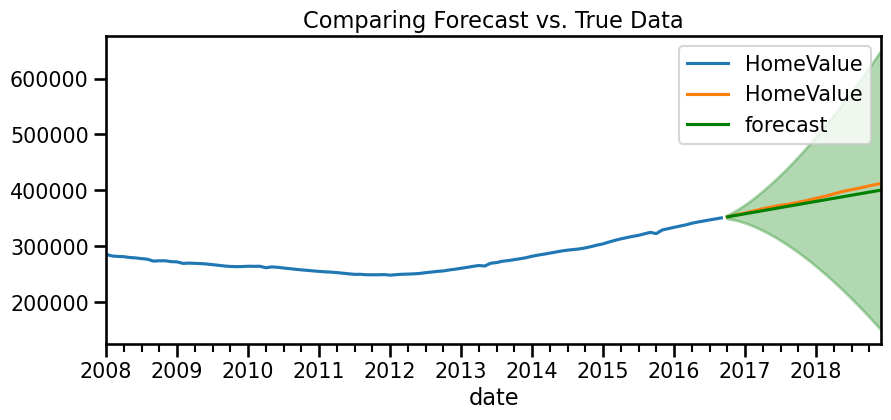

In [117]:
# Obtain summary of forecast as dataframe
forecast_df = sarima.get_forecast(len(test)).summary_frame()
# Plot the forecast with true values
plot_forecast(train, test, forecast_df)
# Obtain metrics
regression_metrics_ts(test, forecast_df["mean"])

definitely going with the tuned auto_arima because the forecast is pretty much spot on with the testing data

In [118]:
forecast_df.index[0], forecast_df.index[-1]

(Timestamp('2016-10-31 00:00:00', freq='M'),
 Timestamp('2018-12-31 00:00:00', freq='M'))

In [119]:
starting_value = forecast_df['mean'].iloc[0]
starting_value

352682.45655090007

In [120]:
final_value = forecast_df['mean'].iloc[-1]
final_value

400599.17918662226

In [121]:
change = final_value - starting_value
change

47916.722635722195

In [122]:
perc_change = (change / starting_value) * 100
perc_change

13.586364092030397

Raw increase: 47916.72

Percentage Change: 13.58%

# Tableau

https://public.tableau.com/views/HomeValues-C/HomeValues?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link